# AI501 Assignment 5: Artitificial Neural Networks



## Import Modules

In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt

torch.manual_seed(0)

## Connect to Your Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = '/gdrive/My Drive'

Mounted at /gdrive


## Set Hyperparameters

In [ ]:
#########################
# hyperparameters
max_epoch = 20
learning_rate = 0.003
batch_size = 128
#########################
device = 'cuda'

## Construct Data Pipeline
*DO NOT MODIFY THIS SECTION FOR EFFICIENT GRADING*

In [ ]:
data_dir = os.path.join(gdrive_root, 'AI501HW5')

train_dataset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ("0","1","2","3","4","5","6","7","8","9")

##Define a Model

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        ##################################
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding = 1)
        self.fc = nn.Linear(784*4, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        ##################################

    def forward(self, x):
        ##################################
        # conv - relu - dropout - max pooling
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        x = self.relu(x)
        x = nn.functional.dropout2d(x, p=0.2, training=True)
        x = nn.functional.max_pool2d(x, 2)
        # conv - relu - dropout - max pooling
        x = self.conv2(x)
        x = self.relu(x)
        x = nn.functional.dropout2d(x, p=0.2, training=True)
        x = nn.functional.max_pool2d(x, 2)
        # flatten
        x = self.flatten(x)
        outputs = self.fc(x)
        ##################################
        return outputs

##Initilize the model and optimizer

In [ ]:
model = Classifier().to(device)
print("Model Structure")
print(model)

#optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# crossentropyloss
cel = nn.CrossEntropyLoss()##

# list of losses for plot
total_train_losses = []
total_test_losses = []
test_acc = []

Model Structure
Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=3136, out_features=10, bias=True)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


##Define the Training Procedure

In [ ]:
def train(epoch):
    model.train()
    train_losses = []
    for i, (x, y) in enumerate(train_loader):
        inputs = x.to(device)
        labels = y.to(device)
        ####################################
        # make prediction
        pred = model(inputs)
        # comput loss
        loss = cel(pred, labels)
        # backpropagate , optimizer steps
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.item())
        ####################################
        if i % (len(train_loader.dataset)//batch_size//4) == 0:
            print('[epoch{:3d}] train loss {:.4f}'.format(epoch, loss.item()))
    train_loss = np.average(train_losses)
    total_train_losses.append(train_loss)
    train_losses = []


##Define the Testing Procedure

In [ ]:
def test(epoch):
    model.eval()
    test_loss = 0
    test_accuracy = 0
    test_losses = []
    for i, (x, y) in enumerate(test_loader):
        inputs = x.to(device)
        labels = y.to(device)
        ####################################
        # make prediction
        pred = model(inputs)
        # compute loss
        loss = cel(pred, labels)
        pred_num = torch.argmax(pred, axis = 1)
        accuracy = torch.sum(pred_num == labels) / batch_size
        test_losses.append(loss.item())
        ####################################
        test_loss += loss.item()*x.size(0)
        test_accuracy += accuracy.item()*x.size(0)
    
    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_acc.append(test_accuracy)
    test_loss1 = np.average(test_losses)
    total_test_losses.append(test_loss1)
    test_losses = []
    print('[epoch{:3d}] test loss {:.4f} test accuracy {:.4f}'.format(epoch, test_loss, test_accuracy)) 

##Training the model

In [ ]:
# Training
for epoch in range(max_epoch):
    train(epoch)
    test(epoch)

# plot train_losses
print("train losses")
plt.ylim([0, 0.5])
plt.plot(total_train_losses)
plt.show()
# plot test_losses
print("test losses")
plt.ylim([0, 0.5])
plt.plot(total_test_losses)
plt.show()
# plot test_losses
print("test accuracy")
plt.ylim([0.9, 1])
plt.plot(test_acc)
plt.show()

## Classify a given data

label : 4
prediction : 4


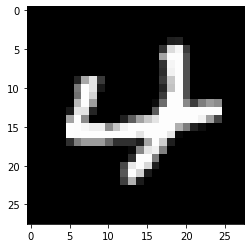

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

model.eval()
random_idx = random.randint(0, len(test_loader.dataset))
test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(model(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(test_input))

## Discussion and Analysis

**model structure**

The model I made has convolutional neural network structure. The input first goes into convolutional layer to extract high-level features and then goes through activation function. I chose relu(Rectified linear unit) as actitivation so it goes through relu layer. I then used dropout with probability 0.2 to prevent too much co-adoption between the weights. Then, it goes through max-pooling to mitigate over-fitting and speed up training. It then goes into convolution layer once more and pass through relu layer. It then dropouts with probability 0.2 and goes through max-pooling. Finally, it is flattened and goes through linear layer to get ten predicted labels.

To summarize, the order is as follows.

conv - relu - dropout - max-pooling  - conv - relu - dropout - max-pooling - linear layer(fully-connected)

These explanations are also in the comments of the code.

\
**model training and testing**

At train time, the input goes through the model and predicts label(number). The loss is then computed(I used crossentropyloss) and then goes through backpropagation process and optimizer steps. 
At test time, it makes prediction and compute loss. 

\
**hyperparameters**

I trained the model with learning rate 0.003, batch size 128, and max epoch 20.

\
**test accuracy**

With max_epoch 20, the model shows accuracy around 98%(0.98) with maximum accuracy 98.8%(0.988).

\
**convergence & overfitting**

As we can see from the plots below (train&test loss, accuracy of every epoch), both the training and test losses converge after some amount of iterations. 

\
**result losses, accuracy**

[epoch  0] train loss 2.3169
[epoch  0] train loss 0.2772
[epoch  0] train loss 0.1333
[epoch  0] train loss 0.1546
[epoch  0] train loss 0.1099
[epoch  0] test loss 0.0572 test accuracy 0.9791

[epoch  1] train loss 0.0622
[epoch  1] train loss 0.0762
[epoch  1] train loss 0.0237
[epoch  1] train loss 0.0593
[epoch  1] train loss 0.1204
[epoch  1] test loss 0.0479 test accuracy 0.9841

[epoch  2] train loss 0.0357
[epoch  2] train loss 0.0321
[epoch  2] train loss 0.0493
[epoch  2] train loss 0.0096
[epoch  2] train loss 0.0187
[epoch  2] test loss 0.0480 test accuracy 0.9818

[epoch  3] train loss 0.0266
[epoch  3] train loss 0.0315
[epoch  3] train loss 0.0083
[epoch  3] train loss 0.0820
[epoch  3] train loss 0.0425
[epoch  3] test loss 0.0414 test accuracy 0.9859

[epoch  4] train loss 0.0064
[epoch  4] train loss 0.0405
[epoch  4] train loss 0.0191
[epoch  4] train loss 0.0248
[epoch  4] train loss 0.0673
[epoch  4] test loss 0.0443 test accuracy 0.9855

[epoch  5] train loss 0.0358
[epoch  5] train loss 0.0355
[epoch  5] train loss 0.0040
[epoch  5] train loss 0.0014
[epoch  5] train loss 0.0657
[epoch  5] test loss 0.0368 test accuracy 0.9866

[epoch  6] train loss 0.0251
[epoch  6] train loss 0.0014
[epoch  6] train loss 0.0300
[epoch  6] train loss 0.0195
[epoch  6] train loss 0.0355
[epoch  6] test loss 0.0383 test accuracy 0.9871

[epoch  7] train loss 0.0090
[epoch  7] train loss 0.0143
[epoch  7] train loss 0.0366
[epoch  7] train loss 0.0062
[epoch  7] train loss 0.0715
[epoch  7] test loss 0.0412 test accuracy 0.9858

[epoch  8] train loss 0.0284
[epoch  8] train loss 0.0039
[epoch  8] train loss 0.0185
[epoch  8] train loss 0.0118
[epoch  8] train loss 0.0264
[epoch  8] test loss 0.0491 test accuracy 0.9839

[epoch  9] train loss 0.0366
[epoch  9] train loss 0.0374
[epoch  9] train loss 0.0049
[epoch  9] train loss 0.0119
[epoch  9] train loss 0.0352
[epoch  9] test loss 0.0447 test accuracy 0.9863

[epoch 10] train loss 0.0640
[epoch 10] train loss 0.0019
[epoch 10] train loss 0.0446
[epoch 10] train loss 0.0004
[epoch 10] train loss 0.0010
[epoch 10] test loss 0.0429 test accuracy 0.9864

[epoch 11] train loss 0.0927
[epoch 11] train loss 0.0214
[epoch 11] train loss 0.0053
[epoch 11] train loss 0.0070
[epoch 11] train loss 0.0088
[epoch 11] test loss 0.0391 test accuracy 0.9886

[epoch 12] train loss 0.0338
[epoch 12] train loss 0.0414
[epoch 12] train loss 0.0050
[epoch 12] train loss 0.0036
[epoch 12] train loss 0.0301
[epoch 12] test loss 0.0426 test accuracy 0.9877

[epoch 13] train loss 0.0306
[epoch 13] train loss 0.0027
[epoch 13] train loss 0.0484
[epoch 13] train loss 0.0017
[epoch 13] train loss 0.0084
[epoch 13] test loss 0.0491 test accuracy 0.9867

[epoch 14] train loss 0.0011
[epoch 14] train loss 0.0296
[epoch 14] train loss 0.0112
[epoch 14] train loss 0.0044
[epoch 14] train loss 0.0523
[epoch 14] test loss 0.0365 test accuracy 0.9880

[epoch 15] train loss 0.0125
[epoch 15] train loss 0.0052
[epoch 15] train loss 0.0084
[epoch 15] train loss 0.0036
[epoch 15] train loss 0.0094
[epoch 15] test loss 0.0445 test accuracy 0.9878

[epoch 16] train loss 0.0195
[epoch 16] train loss 0.0147
[epoch 16] train loss 0.0004
[epoch 16] train loss 0.0106
[epoch 16] train loss 0.0027
[epoch 16] test loss 0.0414 test accuracy 0.9868

[epoch 17] train loss 0.0215
[epoch 17] train loss 0.0011
[epoch 17] train loss 0.0003
[epoch 17] train loss 0.0109
[epoch 17] train loss 0.0109
[epoch 17] test loss 0.0497 test accuracy 0.9864

[epoch 18] train loss 0.0343
[epoch 18] train loss 0.0112
[epoch 18] train loss 0.0621
[epoch 18] train loss 0.0023
[epoch 18] train loss 0.0917
[epoch 18] test loss 0.0566 test accuracy 0.9849

[epoch 19] train loss 0.0123
[epoch 19] train loss 0.0002
[epoch 19] train loss 0.0028
[epoch 19] train loss 0.0454
[epoch 19] train loss 0.0718
[epoch 19] test loss 0.0555 test accuracy 0.9864

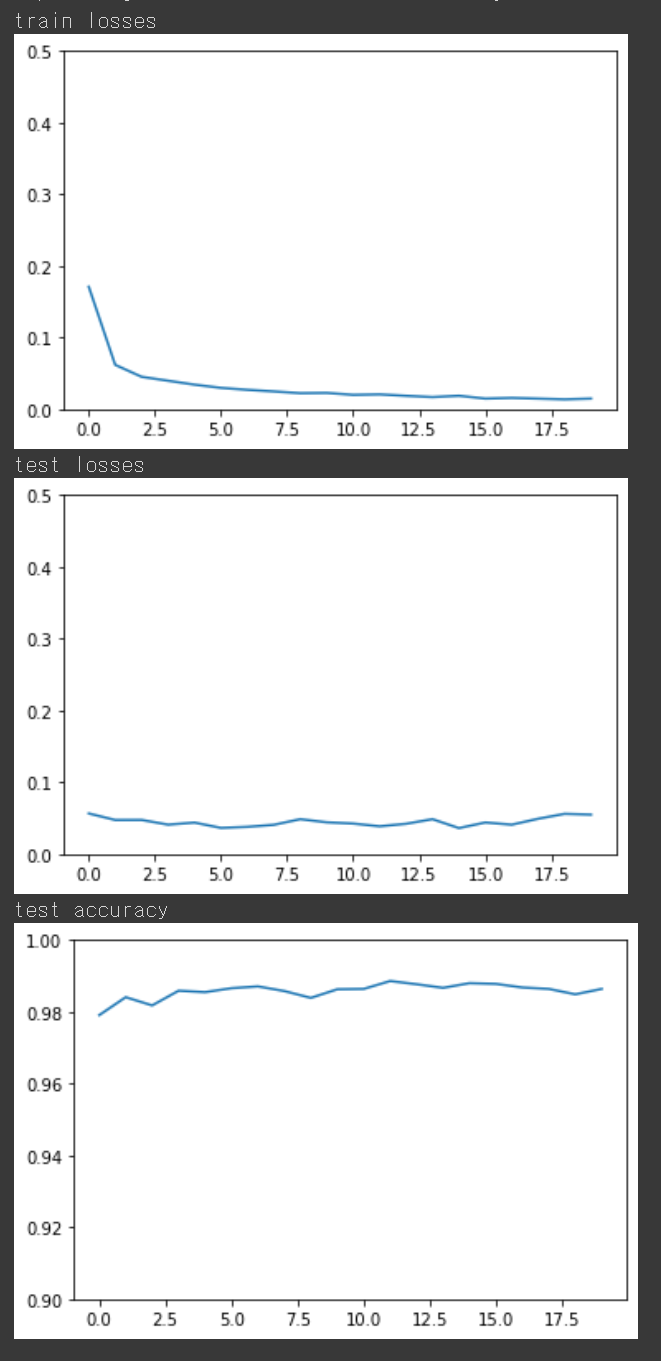